In [0]:
!pip install gym

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import gym
import random
import copy



In [0]:
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1003'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1003'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# PART(A)

## NOTE CAN LOAD ONLY ONE ENVIRONMENT AT A TIME

## Cartpole Env

In [0]:
cartpole_env = gym.make("CartPole-v0")
obs = cartpole_env.reset()
#plt.imshow(env.render('rgb_array'))
print("Observation space:", cartpole_env.observation_space)
print("Action space:", cartpole_env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In [0]:
curr_state = cartpole_env.reste()
isDone = False
while not isDone:
    nexts,rew,isDone,_ = cartpole_env.step(env.action_space.sample())
    print("state:",nexts,"reward:",rew)
    curr_state = nexts 

* cartpole env has two actions, the obseravtion space has 4 paramters cart position, cart velocity, pole angle and pole velocity. Reward is 1 for every step taken and lasts till max of 475 steps

## LunarLander env

In [0]:
!pip install box2d

In [0]:
lunar_env = gym.make("LunarLander-v2")
obs = lunar_env.reset()
#plt.imshow(env.render('rgb_array'))
print("Observation space:", lunar_env.observation_space)
print("Action space:", lunar_env.action_space)

Observation space: Box(8,)
Action space: Discrete(4)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
curr_state = lunar_env.reste()
isDone = False
while not isDone:
    nexts,rew,isDone,_ = lunar_env.step(env.action_space.sample())
    print("state:",nexts,"reward:",rew)
    curr_state = nexts 

4 actions are possible. Reward is -0.3 for every engine fired, if it crashes -100 and if it lands 100 points, leg ground contact is 10 for each leg

# PART(B)

## Policy used by the Policy Gradient Algorithm.
* Softmax policy is implemented

In [0]:
class softmaxPolicy:
    """
        Class that represents the policy. The policy used is Softmax policy with theta as the parameter. The state action features are hot
        encoded and then flattened. 

        πθ(s,a)=softmax=  (e^(ϕ(s,a)⊺θ)) / (∑ e^(ϕ(s,a_k)⊺θ))
    """
    def __init__(self,action_size,state_size):
        self.action_size = action_size
        self.state_size = state_size
        self.theta = np.random.random(self.state_size * self.action_size)

    def phi_sa(self,state,action):
        """
            Feature representation of the state,action pair. One hot encoding is used
        """
        ## Initilaize zero array 
        one_hotenc = np.zeros(shape = (self.action_size,self.state_size))
        ## set the values at the given action index
        one_hotenc[action] = state
        ## return the flattened array
        return one_hotenc.flatten()

    def pi_sa(self,state):
        """
            Return the probability distribution over action space of the envirionment given the state of the environment
        """
        ot = np.zeros(shape=(self.action_size))
        ## Getting the probability for each action given the state
        for j in range(self.action_size):
            ot[j] = np.exp(self.theta.dot(self.phi_sa(state,j)))  ## softmax function is used
        
        return ot/np.sum(ot)

    
    def log_gradient(self,state,action):
        """
            Method used to obtain the gradient of log of the softmax function given the state and action
            ∇θlog(πθ(s,a))=ϕ(s,a)−Eπθ[ϕ(s,⋅)]  ( source : https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative )
        """
        exp = 0
        for a in range(self.action_size):
            exp+= ( self.phi_sa(state,a)* self.pi_sa(state)[a])
        return self.phi_sa(state,action) - exp
    



## Policy Gradient algorithm

In [0]:
class PG:
    """
        This class creates a learning agent that uses Policy Gradient method to learn the given environment. The policy that is used to get the
        probability distribution over the action space given the state of the environment is softmax policy. 
    """
    def __init__(self,policy,env,eps,batch_size,lr,gamma,choice,an = False):
        """
            Initialize the learning agent given the passed parameters. 
        """
        self.env = env
        self.policy = policy    ## Policy used to get the probability distribution
        self.N = eps            ## Number of episodes to run the algorithm
        self.lr = lr            ## The learning rate used to update the parameters of the policy
        self.eps_rew = []       ## To store the reward obtained in a particular episode
        self.gamma = gamma
        self.eps_rec = []
        self.choice = choice    ## Used to choose among vanilla, reward-to-go and Advantage normalization
        self.K = batch_size     ## Batch size represents the number of trajectories used to get the gradients.
        self.advantage_normalization = an    ## Wether to perform advantage normalization or not

    def sai_t(self,time_step,trajectories,choice):
        """
            Method to get the value of Ψ(t). Either implements reward-to-go or vanilla or advantage normalization
        """
        ## Vanilla
        if choice ==0:
            return np.sum([ (self.gamma **t) * r[2] for t,r in enumerate(trajectories)])
        ## Reward-to-go
        elif choice == 1:
            if time_step < len(trajectories):
                return np.sum([ (self.gamma ** (time_step + t)) * r[2] for t,r in enumerate(trajectories[time_step:] ) ])
            else:
                return 0
        ## Advantage Normalization
        else:
            return sai_t(self,time_step,trajectories,1) - self.baseline(time_step)
    
    def baseline(self,trajectories,gradients):
        """
            Implements the baseline function
        """
        ## baseline estimate function
        baseline_t = []
        x =[len(tj) for tj in trajectories]

        for ts in range(np.max(x)):
            tot = 0
            grad_tot = 0
            for trajs,grads in zip(trajectories,gradients):
                if len(grads) > ts:
                    tot+=(self.sai_t(ts,trajs,1) * (grads[ts] ** 2) )
                    grad_tot += (grads[ts] **2)
            baseline_t.append(tot/grad_tot)
        return baseline_t
    
    def train(self):
        """
            Method to train the learning agent using Policy gradient algorithm
        """
        tot_score = 0
        ## Learning of several episodes
        for eps in range(self.N):
            tot_sum = 0 ## stores the total sum of the gradients for all self.E trajectories
            tot_score = 0
            traj = []     ## stores k trajectories
            gradj = []    ## stores gradients for each time step of each trajectory
            scorej = []   ## stores the total score in each trajectory

            ## Collecting K trajectories using current policy with theta parameters
            for curr_traj in range(self.K):
                curr_state = self.env.reset()
                trajectories = []
                grads = []
                isDone = False
                score = 0
                # Create the trajectory till the final state is reached
                while not isDone:
                    pi_sa = self.policy.pi_sa(curr_state)
                    action = np.random.choice(self.env.action_space.n,p = pi_sa)
                    next_state,reward,isDone,_ = self.env.step(action)
                    trajectories.append((curr_state,action,reward))
                    grads.append(self.policy.log_gradient(curr_state,action))  ## Calculating gradient at each time step of the current episode
                    curr_state = next_state
                    score+=reward
                ## storing the trajectory, gradient and score
                traj.append(trajectories)
                gradj.append(grads)
                scorej.append(score)

            ## For computing baseline used when advantage nomralization is used
            if self.advantage_normalization == True:
                ##computing baseline:
                baseline_t = self.baseline(traj,gradj)
            ## Computing the expectation over K trajectories
            tot_sum = 0    
            for trajectories,grads in zip(traj,gradj):
                inner_sum = 0
                ## Computing the summation of  ( product of (log_gradient and the Ψ(t) ) )
                for ts in range(len(trajectories)):
                    grad = grads[ts]
                    if self.advantage_normalization == True:
                        inner_sum += grad * (self.sai_t(ts,trajectories,self.choice) - baseline_t[ts])
                    else:
                        inner_sum += grad * (self.sai_t(ts,trajectories,self.choice))
                tot_sum+=inner_sum

            tot_score = np.sum(scorej) / self.K
            ## Performing gradient update
            self.policy.theta += self.lr * (tot_sum/self.K)
            if eps%100 == 0 or eps == self.N - 1:
                print("eps:",eps,"score:",tot_score)
            if eps%25 == 0 or eps == self.N-1:
                self.eps_rec.append(eps)
                self.eps_rew.append(tot_score)

## For Cartpole

## Study of using vanilla, reward-to-go and advantage normalization 
### Batch size of 50

## Using Normal 

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
episodes = 1600
batch_size = 50
learning_rate = 0.00025
gamma = 0.99
choice = 0 ## to choose between vanilla, reward-to-go, and advantage function
pg = PG(policy,cartpole_env,episodes,batch_size,learning_rate,gamma,0)
pg.train()

eps: 0 score: 21.12
eps: 100 score: 33.2
eps: 200 score: 37.6
eps: 300 score: 50.2
eps: 400 score: 67.94
eps: 500 score: 107.42
eps: 600 score: 140.16
eps: 700 score: 152.22
eps: 800 score: 164.32
eps: 900 score: 172.06
eps: 1000 score: 166.44
eps: 1100 score: 174.32
eps: 1200 score: 176.8
eps: 1300 score: 183.12
eps: 1400 score: 190.54
eps: 1500 score: 184.44
eps: 1599 score: 190.18


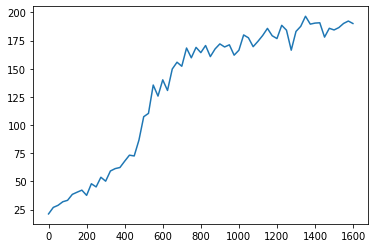

In [0]:
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

## Using reward-to-go function

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1600,50,0.00025,0.99,1)
pg.train()

eps: 0 score: 16.86
eps: 100 score: 22.04
eps: 200 score: 37.44
eps: 300 score: 44.84
eps: 400 score: 53.76
eps: 500 score: 60.14
eps: 600 score: 68.9
eps: 700 score: 112.0
eps: 800 score: 142.46
eps: 900 score: 168.14
eps: 1000 score: 179.02
eps: 1100 score: 182.82
eps: 1200 score: 188.04
eps: 1300 score: 184.24
eps: 1400 score: 190.78
eps: 1499 score: 193.46


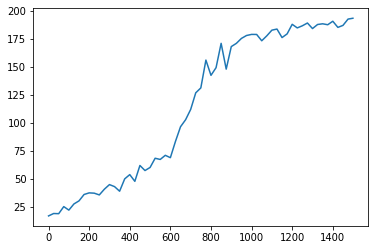

In [0]:
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

## Using Advantage Normalization

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1600,50,0.00025,0.99,1,True)
pg.train()

eps: 0 score: 35.22
eps: 100 score: 47.74
eps: 200 score: 74.72
eps: 300 score: 108.88
eps: 400 score: 119.8
eps: 500 score: 153.5
eps: 600 score: 177.4
eps: 700 score: 180.84
eps: 800 score: 181.76
eps: 900 score: 183.62
eps: 1000 score: 186.84
eps: 1100 score: 188.36
eps: 1200 score: 186.08
eps: 1300 score: 191.72
eps: 1400 score: 190.54
eps: 1499 score: 195.68


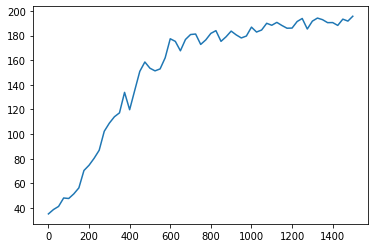

In [0]:
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

## Observations
* For several runs the advantage normalization technique produced scores of greater than 192 or 191. second performing was the reward-to-go technique. and the least was the vanilla technique.

* The increase in score for the advantage function technique was greater in initial episodes ( the slope in the firs 200 episodes is more). whereas it was lesser for reward-to-go and vanilla technique.

* Also there is less performance drops and gains ( zig-zag pattern) in the advantage function tenchnique. This pattern was significantly higher for the vanilla technique

## For LunarLander

In [0]:
policy = softmaxPolicy(lunar_env.action_space.n,lunar_env.observation_space.shape[0])
total_episodes = 1500
batch_size = 100
learning_rate = 0.0025
gamma = 0.99
choice = 1
pg = PG(policy,lunar_env,total_episodes,batch_size,learning_rate,gamma,choice)
print("Score printed is average over 100 episodes")
pg.train()

Score printed is average over 100 episodes
eps: 0 score: -142.38303268268703
eps: 100 score: 1.9736066901453244
eps: 200 score: -15.616745808811185


## Plot not generated since training time is high takes about an hour for 100 episodes

In [0]:
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

In [0]:
np.savetxt('theta.out',pg.policy.theta,delimiter = ',')

#PART (C)

### Study of learning curve given varying number of batch_size
* Study done on cartpole environment

#### Batch Size 10

eps: 0 score: 24.5
eps: 100 score: 30.8
eps: 200 score: 49.4
eps: 300 score: 58.4
eps: 400 score: 83.5
eps: 500 score: 72.3
eps: 600 score: 101.0
eps: 700 score: 113.3
eps: 800 score: 133.0
eps: 900 score: 134.3
eps: 1000 score: 159.7
eps: 1100 score: 144.9
eps: 1200 score: 161.2
eps: 1300 score: 165.4
eps: 1400 score: 154.2
eps: 1499 score: 168.0


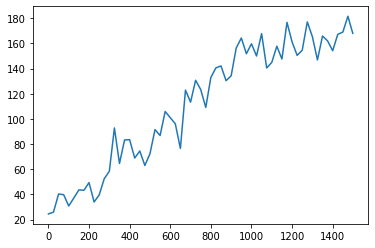

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1500,10,0.00025,0.99,1,True)
pg.train()
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

#### Batch Size 20

eps: 0 score: 32.6
eps: 100 score: 38.15
eps: 200 score: 34.5
eps: 300 score: 43.65
eps: 400 score: 60.05
eps: 500 score: 47.25
eps: 600 score: 61.35
eps: 700 score: 58.5
eps: 800 score: 60.8
eps: 900 score: 83.0
eps: 1000 score: 94.65
eps: 1100 score: 116.8
eps: 1200 score: 119.7
eps: 1300 score: 155.85
eps: 1400 score: 181.2
eps: 1499 score: 185.9


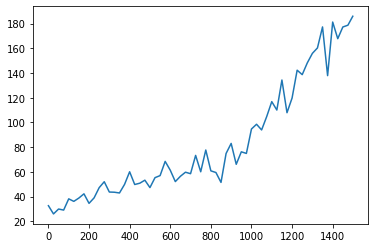

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1500,20,0.00025,0.99,1,True)
pg.train()
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

Batch Size 30

eps: 0 score: 16.566666666666666
eps: 100 score: 24.1
eps: 200 score: 33.233333333333334
eps: 300 score: 40.333333333333336
eps: 400 score: 63.8
eps: 500 score: 58.5
eps: 600 score: 97.83333333333333
eps: 700 score: 119.96666666666667
eps: 800 score: 127.33333333333333
eps: 900 score: 152.76666666666668
eps: 1000 score: 168.63333333333333
eps: 1100 score: 172.2
eps: 1200 score: 169.93333333333334
eps: 1300 score: 176.6
eps: 1400 score: 176.26666666666668
eps: 1499 score: 191.4


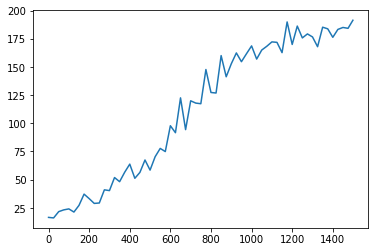

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1500,30,0.00025,0.99,1,True)
pg.train()
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

Batch Size 40

eps: 0 score: 22.25
eps: 100 score: 23.225
eps: 200 score: 33.4
eps: 300 score: 40.225
eps: 400 score: 52.55
eps: 500 score: 50.625
eps: 600 score: 65.4
eps: 700 score: 62.925
eps: 800 score: 84.3
eps: 900 score: 100.0
eps: 1000 score: 115.55
eps: 1100 score: 140.075
eps: 1200 score: 163.725
eps: 1300 score: 185.7
eps: 1400 score: 184.975
eps: 1499 score: 177.675


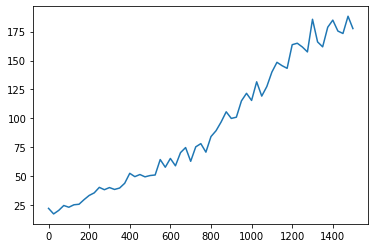

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1500,40,0.00025,0.99,1,True)
pg.train()
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

#### Batch Size 100

eps: 0 score: 18.92
eps: 100 score: 23.72
eps: 200 score: 32.91
eps: 300 score: 46.44
eps: 400 score: 59.67
eps: 500 score: 77.44
eps: 600 score: 92.89
eps: 700 score: 123.01
eps: 800 score: 151.61
eps: 900 score: 166.43
eps: 1000 score: 178.63
eps: 1100 score: 180.74
eps: 1200 score: 188.16
eps: 1300 score: 186.99
eps: 1400 score: 179.49
eps: 1499 score: 184.23


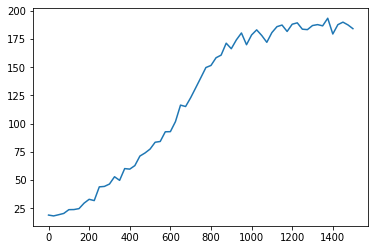

In [0]:
policy = softmaxPolicy(cartpole_env.action_space.n,cartpole_env.observation_space.shape[0])
pg = PG(policy,cartpole_env,1500,100,0.00025,0.99,1,True)
pg.train()
plt.plot(pg.eps_rec,pg.eps_rew)
plt.show()

* For batch size of 10 the final average score attained in 1500 episode is less than 180. Also there is too much zig zag or dropping and gaining of values that can be seen from the graph.

* For batch size of 20,30,40 the final scores reached is 185, 190 and above, They are better than the batch size of 10. Still the zig zag or dropping and gaining performance is observerd.

* For batch size of 50 (the graph is shown earlier) the zig-zag pattern is less.
* For batch size of 100 the zig-zag pattern is even lesser.